In [16]:
#Cargando librerías 
import importlib

import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd

import src.positioning_sensors as ps
import src.regionGrowing as rg
import src.manageExperiments as me
import src.network_fitness as netfit

importlib.reload(ps)
importlib.reload(rg)
importlib.reload(me)
importlib.reload(netfit)

from geneticalgorithm import geneticalgorithm as ga

import itertools as it

plt.style.use("seaborn-poster")


In [17]:
setup = me.readConfigFile("config_exp_13062022.txt")

In [18]:
#cargamos imagenes en luminance e importance
ilumina = setup["folder_input"]+setup["input_ntli"]
niveles = setup["folder_input"]+setup["input_evm"]
sigma_y = setup['filterg_sy']
sigma_x =setup['filterg_sx']
sigma = [sigma_y,sigma_x]

#Loading precalculated local and directed empirical variograms

filesv = setup["experiment_id"]+setup["folder_semivariances"]+setup["output_semivariances"]+".csv"
filesvmask = setup["experiment_id"]+setup["folder_semivariances"]+setup["output_semivariances"]+"mask.csv"

OptimumValues = setup["experiment_id"]+setup["folder_output"]+setup["output_values"]
arguments = setup["experiment_id"]+setup["folder_output"]+setup["output_args"]


data = pd.read_csv(filesv)
data_m = pd.read_csv(filesvmask)
variogram_set = np.array(data.iloc[:,3:])
variogram_set_m = np.array(data_m.iloc[:,3:])


#NLTI: luminance
luminance = ps.readIMG(ilumina)

#EAM: Environtmental attention map is the importance
EAM = ps.readIMG(niveles,invert=True)

nonsat,b = ps.desaturate(luminance,th=63)

variograms = variogram_set.reshape(len(variogram_set),nonsat.shape[0],nonsat.shape[1])
variograms_m = variogram_set_m.reshape(len(variogram_set),nonsat.shape[0],nonsat.shape[1])

coords = np.array(data.iloc[:,1:3])

#nonsat2 = sp.ndimage.filters.gaussian_filter(nonsat, sigma, mode='constant')
#nonsat2 = (nonsat2>=22)*nonsat2

NLTI = sp.ndimage.filters.gaussian_filter(nonsat, sigma, mode='constant')
NLTI = (NLTI>=22)*NLTI
sensitivity = ps.f5(NLTI,EAM,64)

 W = i*a^(p)


In [25]:
OptimumValues

'exp_050512022_consider_flat/results/optimum_values.csv'

In [22]:
#res_df= pd.DataFrame(results)
#res_df.to_csv("results_7x7.csv")
res_read = pd.read_csv(OptimumValues)
rr = np.array(res_read)
r = list([])
for i,j in enumerate(rr):
    r.append(j[1:(1)+((i % 7) +1)*2])

In [23]:
aptitude = netfit.NetworkFitness(NLTI,EAM,sensitivity,variograms,variograms_m,coords)
aptitude.selectFitnessFunction("max")


Selct cost functions: 
 'xor','max' or 'cover'


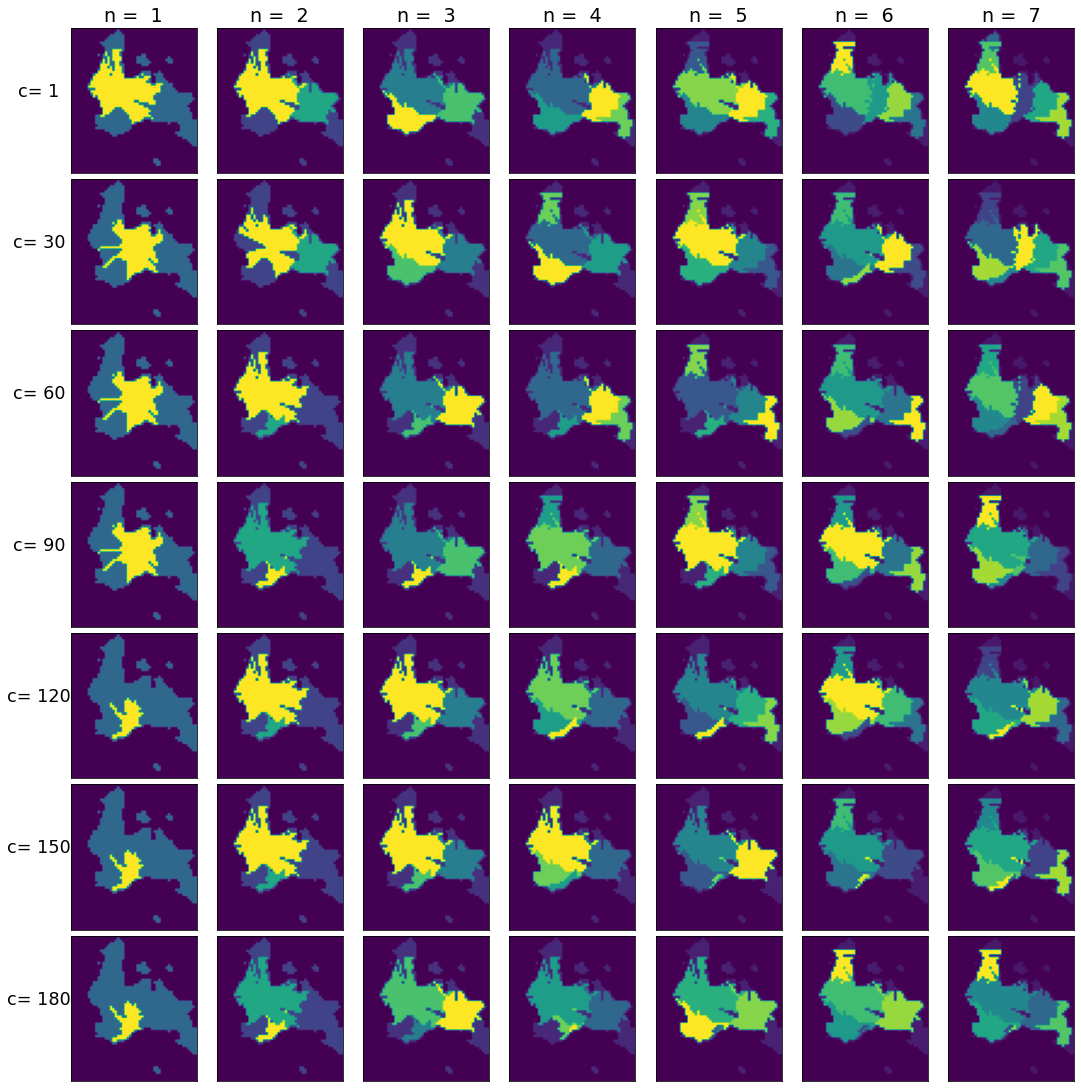

In [24]:

fig, axs = plt.subplots(ncols=7, nrows=7, figsize=(15, 15),constrained_layout=True)

# add an artist, in this case a nice label in the middle...
ix = 0
allc = [1, 30, 60, 90, 120, 150, 180]
#cs = [1,30,60,90,120,150]
for row in range(len(allc)):
    for col in range(7):
        R = aptitude.project(r[ix])+(nonsat>0)/2
        #R_and_locations = AttachLocations(R,results)
        axs[row,col].imshow(R)

        
        if col==0: 
            axs[row, col].set_ylabel("c={c: 1.0f}".format(c = allc[row]),rotation = 0)
            axs[row, col].yaxis.set_label_coords(-.25, .5)
        if row==0: 
            axs[row, col].set_title('n = {n: 1.0f}'.format(n=col+1))
            #axs[row, col].set_xlabel("n = {n: 1.0f}".format(n=col+1))
            
        axs[row, col].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

        ix += 1


plt.savefig("covers64.eps",bbox_inches="tight")

plt.show()

In [26]:
aptitudes = np.array(pd.read_csv(arguments))[:,1]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


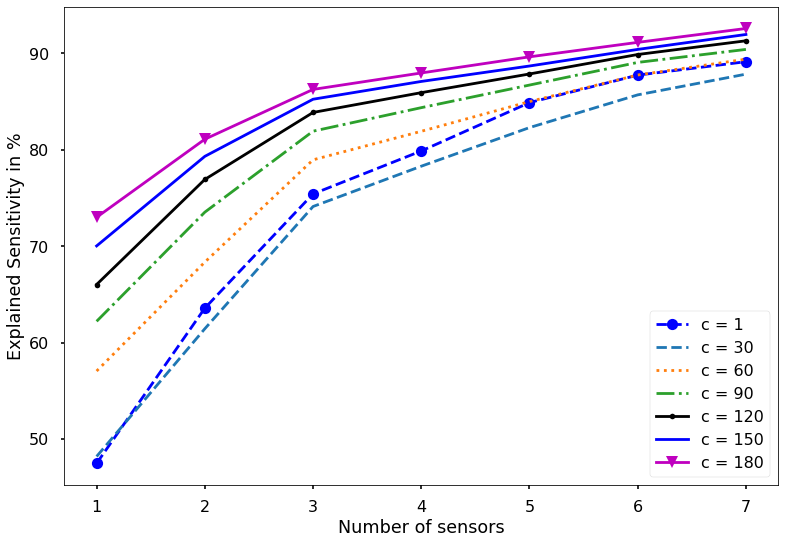

In [27]:
c = [1,30,60,90,120,150,180]

fig, ax = plt.subplots()
styles = ['--bo','--',':','-.','.-k','b','-vm']
for i in range(7):
    ax.plot(-aptitudes.reshape(7,7).T[:,i]*100,styles[i],label="c = "+str(c[i]))

ax.set_xticks([i for i in range(len(c))])
ax.set_xticklabels([i+1 for i in range(len(c))])
ax.set_ylabel("Explained Sensitivity in %")
ax.set_xlabel("Number of sensors")
ax.legend()
plt.savefig("ExplainedSensitivity64.eps",bbox_inches="tight")
plt.show()